In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import mkl
import time

In [2]:
%matplotlib inline

## Floats vs Ints in Matrix Multiplication

In [14]:
a = np.random.randint(low=0, high=100, size=[1000, 1000])
b = np.random.randint(low=0, high=100, size=[1000, 1000])

In [15]:
a.dtype

dtype('int64')

In [ ]:
%%timeit
res = a @ b

In [16]:
c = a.astype(float)
d = b.astype(float)

In [ ]:
%%timeit
res = c @ d

## Bottlneck the number of threads

In [13]:
import mkl
import time

c and d are both numpy arrays of float with shape [1000,1000]

In [17]:
n_threads = [1, 2, 4, 8, 16, 32, 64, 96]
times = {}
for n in n_threads:
    mkl.set_num_threads_local(n)
    start = time.time()
    res = c @ d
    stop = time.time()
    times[n] = stop - start

/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


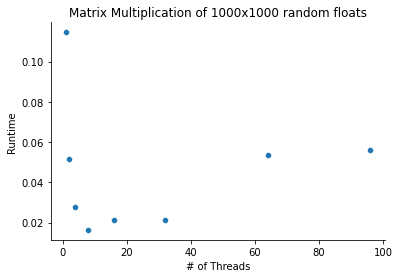

In [19]:
ax = sns.scatterplot(times.keys(), times.values())
ax.set(xlabel='# of Threads',
       ylabel='Runtime',
       title='Matrix Multiplication of 1000x1000 random floats')
sns.despine()
plt.show()

## Mulitprocessing in python

Note, the code and data for this isn't availble right now online, but I can share it later

In [3]:
from egad import run_egad
import multiprocessing as mp

In [4]:
networks_path = '/data/bharris/biccn_paper/data/bulk_rna/networks/'
datasets = np.genfromtxt(
    '/data/bharris/biccn_paper/data/bulk_rna/datasets_used.csv', dtype=str)
file_names = [f'{networks_path}{ds}_pearson_nw.hdf5' for ds in datasets]

In [5]:
datasets.shape

(52,)

### Sequential

In [48]:
%%time
go = pd.read_hdf('~/GO_data/go_mouse_nw.hdf5', 'go')
res = []
for fn in file_names:
    nw = pd.read_hdf(fn, 'nw')
    res.append(run_egad(go, nw).AUC.mean())

CPU times: user 2h 28min 48s, sys: 56min 19s, total: 3h 25min 7s
Wall time: 11min 3s


### Multiprocessing Manager

In [50]:
def egad_test(fn,name, return_dict):
    go = pd.read_hdf('~/GO_data/go_mouse_nw.hdf5', 'go')
    nw = pd.read_hdf(fn, 'nw')
    return_dict[name] = run_egad(go, nw).AUC.mean()

In [51]:
%%time
manager = mp.Manager()
return_dict = manager.dict()
jobs = []
for fn, name in zip(file_names, datasets):
    p = mp.Process(target=egad_test, args=(fn, name, return_dict))
    jobs.append(p)
    p.start()
for proc in jobs:
    proc.join()

CPU times: user 76 ms, sys: 11.7 s, total: 11.8 s
Wall time: 2min 52s


### Multiprocessing Map

In [6]:
def egad_test_map(fn):
    go = pd.read_hdf('~/GO_data/go_mouse_nw.hdf5', 'go')
    nw = pd.read_hdf(fn, 'nw')
    return run_egad(go, nw).AUC.mean()

In [8]:
%%time
pool = mp.Pool(10)
map_res = pool.map(egad_test_map, file_names)
pool.close()
pool.join()

CPU times: user 306 ms, sys: 242 ms, total: 548 ms
Wall time: 2min 51s


## Vectorization

In [ ]:
## List Comprehension
listB = [function(a) for a in listA]

## For loop
listB = []
for a in listA:
    listB.append(function(a))

    
## Vectorization
vector_func = np.vectorize(function)
listB = vector_func(listA)

In [20]:
rands = np.random.rand(1000,1000)

In [30]:
%%timeit
rowSums = []
for row in range(rands.shape[0]):
    rowSums.append(sum(rands[row,:]))

221 ms ± 2.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%%timeit
rowSums = np.sum(rands, axis=1)

477 µs ± 825 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [39]:
rands_df = pd.DataFrame(rands)

In [40]:
%%timeit
res = rands_df.sum(axis=1)

6.41 ms ± 24.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
%%timeit
res = np.sum(rands_df,axis=1)

7.1 ms ± 3.05 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
%%timeit
res = rands_df.values.sum(axis=1)

476 µs ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [43]:
%%timeit
res = np.sum(rands_df.values, axis=1)

482 µs ± 17 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
